In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal

import h5py
import DasPrep as dp

datapath = 'J:\\xfj_dam_test1\\'
workpath = 'E:\\sustech_dir\\xfj_dam_das\\rtk_hammer_shot_data\\'

hs_catalog_file = 'E:\\sustech_dir\\xfj_dam_das\\OB_20220916113905_rtk.txt'

In [2]:
hs_cat = pd.read_csv(hs_catalog_file, delim_whitespace=True)
hs_cat.head(5)

,FFID,Line,Point,Gps-time(us)-UTC,Date,UTC-Time,Time-Source,Latitude,Longitude,Comment
0,1,1.0,1.0,1347329106226803,2022-09-16,02:04:48.226803,GPS,234343.860,1143858.884,NaN
1,2,1.0,2.0,1347329114764543,2022-09-16,02:04:56.764543,GPS,234343.932,1143858.884,NaN
2,3,1.0,3.0,1347329120619154,2022-09-16,02:05:02.619154,GPS,234343.860,1143858.884,NaN
3,4,1.0,4.0,1347329135425238,2022-09-16,02:05:17.425238,GPS,234343.788,1143858.848,NaN
4,5,1.0,5.0,1347329159007710,2022-09-16,02:05:41.007710,GPS,234343.716,1143858.884,NaN


In [3]:
def get_cat_time(catalog):
    cat_time = np.array([datetime.datetime.strptime(str(catalog['Date'].values[i])+' '+str(catalog['UTC-Time'].values[i]), '%Y-%m-%d %H:%M:%S.%f') 
       for i in range(len(catalog))])
    return cat_time

hs_time = get_cat_time(hs_cat)

lat = hs_cat['Latitude'].values
lon = hs_cat['Longitude'].values

<IPython.core.display.Javascript object>


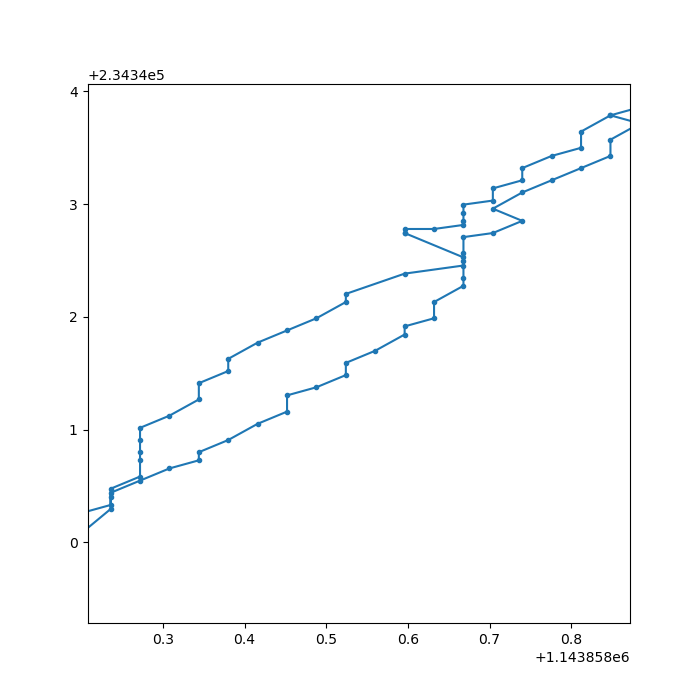

In [34]:
plt.figure(figsize=[7,7])
plt.plot(lon, lat,'.-')
plt.plot(lon[0], lat[0], 'r.')

In [4]:
%%time
das_file = glob.glob(datapath+'*')
das_file.sort()

Wall time: 41 ms


In [5]:
das_file

['J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101425.758.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101557.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101612.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101627.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101642.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101657.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101712.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101727.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101742.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101757.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_05m_UTC_20220915_101812.658.h5',
 'J:\\xfj_dam_test1\\xfj_dam_idas_GL_3m_freq_2kHz_sp_0

In [6]:
def read_das_data(filename):
    data, dt = dp.read_h5(filename)
    nt = data.shape[1]
    return data, dt, nt

def get_das_file_time(das_filename):
    das_file_time_str = ' '.join(os.path.splitext(os.path.basename(das_filename))[0].split('_')[-2:])
    return datetime.datetime.strptime(das_file_time_str, '%Y%m%d %H%M%S.%f')

def get_ev_id_in_das_window(event_time_arr, start_time, end_time):
    return np.where((event_time_arr > start_time) & (event_time_arr < end_time))

def get_time_step(start, end, dt):
    return int((start - end).total_seconds() / dt + 1)


def extract_das_data(das_file, ev_time, dt_before, dt_after, save_file_name_prefix, overwrite=False, verbose=False):
    
    das_file_time = np.array([get_das_file_time(das_file[i]) for i in range(len(das_file))])
    
    ev_id_in_das_win = get_ev_id_in_das_window(ev_time, das_file_time.min(), das_file_time.max())
    ev_time_in_das_win = ev_time[ev_id_in_das_win]
    
    ev_time_before = ev_time_in_das_win - datetime.timedelta(seconds=dt_before)
    ev_time_after  = ev_time_in_das_win + datetime.timedelta(seconds=dt_after)

    for iev in range(len(ev_id_in_das_win[0])):

        savename = save_file_name_prefix + str(ev_id_in_das_win[0][iev]) + '.npy'
        
        if verbose: print(savename)

        if not (os.path.exists(savename) and not overwrite):

            ins_start = np.searchsorted(das_file_time, ev_time_before[iev:(iev+1)])[0] - 1
            ins_end = np.searchsorted(das_file_time, ev_time_after[iev:(iev+1)])[0]

            das_file_time_select = das_file_time[ins_start:ins_end]
            das_file_select = das_file[ins_start:ins_end]

            ev_t0 = ev_time_before[iev]
            ev_t1 = ev_time_after[iev]

            data = []
            for i in range(len(das_file_select)):
#                 print(das_file_select[i])

                datatmp, dt, nt = read_das_data(das_file_select[i])
                istart, iend = 0, np.copy(nt)

                das_t0 = das_file_time_select[i]
                das_t1 = das_t0 + datetime.timedelta(seconds=dt*nt)

                if ev_t0 > das_t0:
                    istart = get_time_step(ev_t0, das_t0, dt)

                if ev_t1 < das_t1:
                    iend = get_time_step(ev_t1, das_t0, dt)

                data.append(datatmp[:, istart:iend])

            data = np.concatenate(data, axis=1)
            if (data.size > 0):
                np.save(savename, data.astype('float32'))

In [7]:
%%time

dt_before, dt_after = 1, 2

save_file_name_prefix = workpath + 'xfj_das_hs_'

extract_das_data(das_file, hs_time, dt_before, dt_after, 
                 save_file_name_prefix, overwrite=True, verbose=True)

E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_0.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_1.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_2.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_3.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_4.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_5.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_6.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_7.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_8.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_9.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_10.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_11.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_12.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_13.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_14.npy
E:\sustech_dir\xfj_d

E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_124.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_125.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_126.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_127.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_128.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_129.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_130.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_131.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_132.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_133.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_134.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_135.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_136.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_137.npy
E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_138

In [29]:
%%time 
from scipy import signal

def bandpass(data, dt, fl, fh):
    fs=1/dt
    sos = signal.butter(6, [fl/(fs/2), fh/(fs/2)], 'bp', output='sos')
    data = signal.sosfiltfilt(sos, data, axis=1)
    return data

ieq = 0
savename = save_file_name_prefix + str(ieq) + '.npy'

dt = 1./2000.
print(savename)
data = np.load(savename)

data = dp.das_preprocess(data)
f1, f2 = 50, 999
data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

# data = data.cumsum(axis=1) * dt
# data = idas.das_preprocess(data)


E:\sustech_dir\xfj_dam_das\rtk_hammer_shot_data\xfj_das_hs_0.npy
Wall time: 3.03 s


<IPython.core.display.Javascript object>


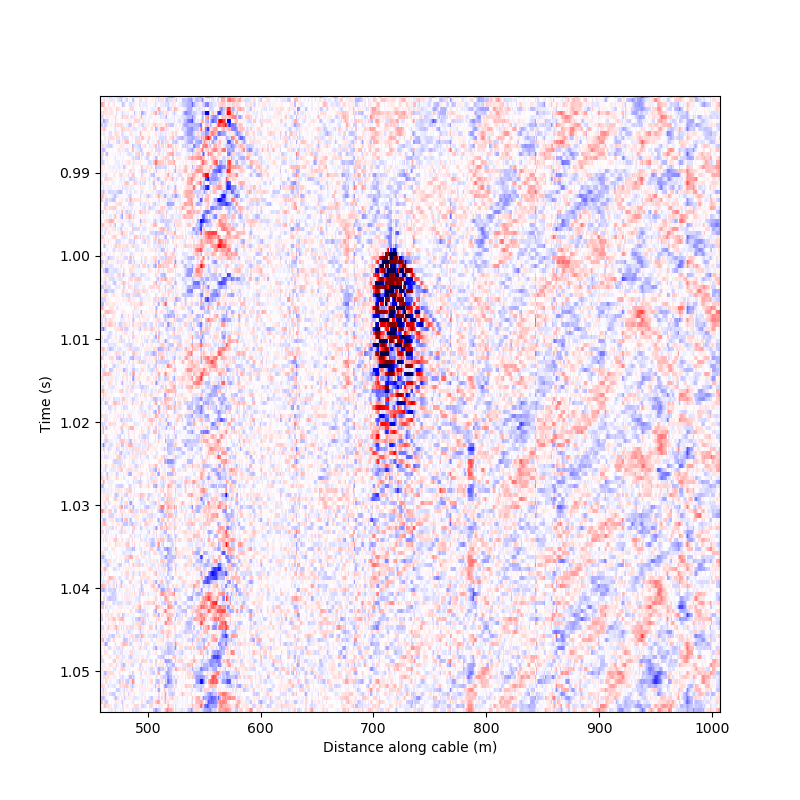

In [35]:
%matplotlib notebook
 # %matplotlib inline


plt.figure(figsize=[8,8])

clim = data.std() * 1

plt.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

plt.ylabel('Time (s)')
plt.xlabel('Distance along cable (m)')
arglist = ['Date', 'Time', 'Lat.', 'Lon.', 'Mag.', 'Dep.']


